In [1]:
import sys
from pathlib import Path

# Add the src directory to the Python path
sys.path.append(str(Path().resolve().parent / "src"))

# Import necessary libraries
import torch
import torch.nn as nn
import shap
from torchvision import models, transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from config import MODEL_DIR, MODEL_NAME, DEVICE
from model.architecture_config import get_multimodal_cnn_model
import config
from model.train import LandslideDataset



c:\Users\phili\torch1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model from D:\Landslide-Image-Classification\models\landslide_MMCNN_V2\landslide_MMCNN_V2_0.pth


<All keys matched successfully>

In [3]:

device = torch.device(config.DEVICE)

# Create dataset with data loaded into memory
print("Loading dataset into memory...")
dataset = LandslideDataset(
    image_dir=config.PROCESSED_TRAIN_IMAGE_DIR,
    csv_path=config.TRAIN_CSV_PATH,
    device=device
)

Loading dataset into memory...


Loading images: 100%|██████████| 7147/7147 [00:03<00:00, 2273.38it/s]

Loaded 7147 valid images out of 7147
Total memory usage: 1.09 GB


In [ ]:
# Load all model checkpoints from the cross-validation folder
model_dir = MODEL_DIR / MODEL_NAME
model_path = glob.glob(str(model_dir / f"{MODEL_NAME}_*.pth"))[0]

print(f"Loading model from {model_path}")
model = get_multimodal_cnn_model(dropout=0.0, final_dropout=0.0).to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

In [61]:
data_loader = DataLoader(
            dataset,
            batch_size=140,
            shuffle=True,
            num_workers=0,
            generator=torch.Generator().manual_seed(config.SEED)
        )

for _, (images, targets) in enumerate(data_loader):
    break

background = images[:100]
test_images = images[100:]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images, check_additivity=False)

In [64]:
test_images[0, :2, :, :].shape

torch.Size([2, 64, 64])

In [64]:
[np.mean(mat) for mat in np.abs(shap_values[-8,:,:,:, 0])]

[np.float64(0.0017512145736498855),
 np.float64(0.001475055009257903),
 np.float64(0.0016293728758802056),
 np.float64(0.0034438531808352463),
 np.float64(0.002381961917536087),
 np.float64(0.003524848046072296),
 np.float64(0.0032852178477098537),
 np.float64(0.0018181842203370546),
 np.float64(0.0016753856767070807),
 np.float64(0.002708383931396212)]

In [62]:
targets[100:]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0.])

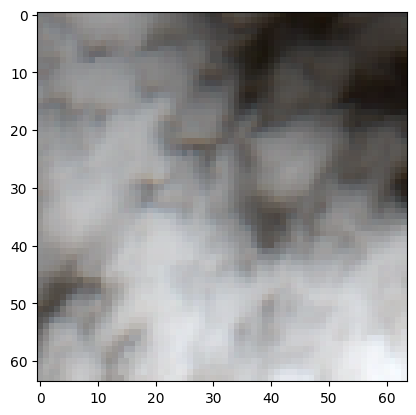

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.1853483644918015e-06..1.4625683426856995].


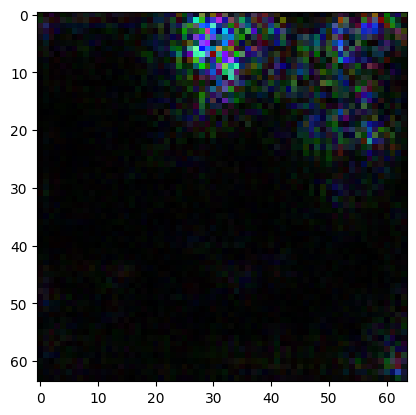

In [67]:
img = test_images[-2, :3, :, :].permute(1, 2, 0).cpu().data.numpy()
if np.min(img) < 0:
    img = img - np.min(img)
img = img / np.max(img)
plt.imshow(img)
plt.show()

plt.imshow(np.abs(shap_values[-2,:3,:,:, 0]).transpose(1, 2, 0) * 10)
plt.show()


In [47]:
np.max(np.abs(shap_values[-8,:3,:,:, 0]).transpose(1, 2, 0) * 10)

np.float64(0.20671378821134567)